In [1]:
%load_ext autoreload
%autoreload 2
%pdb
%matplotlib inline

Automatic pdb calling has been turned ON


In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [5]:
df_district = get_district_time_series(dataframes)

## Create train-val splits

In [6]:
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

## Loss Calculation Functions

In [7]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Set priors for parameters of interest

In [8]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1, 3)#(1.6, 3)
prior_ranges['T_inc'] = (1, 5) #(4, 5)
prior_ranges['T_inf'] = (1, 4) #(3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)
prior_ranges['sigma'] = (0, 1)

def param_init():
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [9]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.025 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))


## Log Likelihood and Prior

In [10]:
def log_likelihood(theta):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])
    true = np.array(df_train['total_infected'])
#     sigma = theta['c_sigma'] * true.std()
    sigma = theta['sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
#     prior = 1
#     for key in prior_ranges:
#         if in_valid_range(key, theta[key]):
#             prior *= 1 / (prior_ranges[key][1] - prior_ranges[key][0])
#         else:
#             prior = 0
#             break
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [11]:
def accept(theta_old, theta_new):    
    x_new = log_likelihood(theta_new) + log_prior(theta_new)
    x_old = log_likelihood(theta_old) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [12]:
def metropolis(iter=1000):
    theta = param_init()
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta)
        if anneal_accept(i):
            theta = theta_new
        else:
            if accept(theta, theta_new):
                theta = theta_new
            else:
                rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

## Prediction Interval calculator

In [21]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Run multiple chains in parallel

In [14]:
mcmc = Parallel(n_jobs=5)(delayed(metropolis)(iter=10000) for run in range(5))

## Visualize the samples and intervals

In [24]:
def visualize(): 
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    combined_acc = list()
    for k, run in enumerate(mcmc):
        burn_in = int(len(run) / 2)
        combined_acc += run[0][burn_in:]

    n_samples = 1000
    sample_indices = np.random.uniform(0, len(combined_acc), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(combined_acc[int(i)], default_params, data_split))

    for df in pred_dfs:
        df.set_index('date', inplace=True)

    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''

    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

    data_split.set_index("date", inplace=True)

    plt.figure(figsize=(15, 10))
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% confidence intervals")
    
    plt.savefig('./mcmc_confidence_intervals.png')
    plt.show()

100%|██████████| 48/48 [00:06<00:00,  7.01it/s]


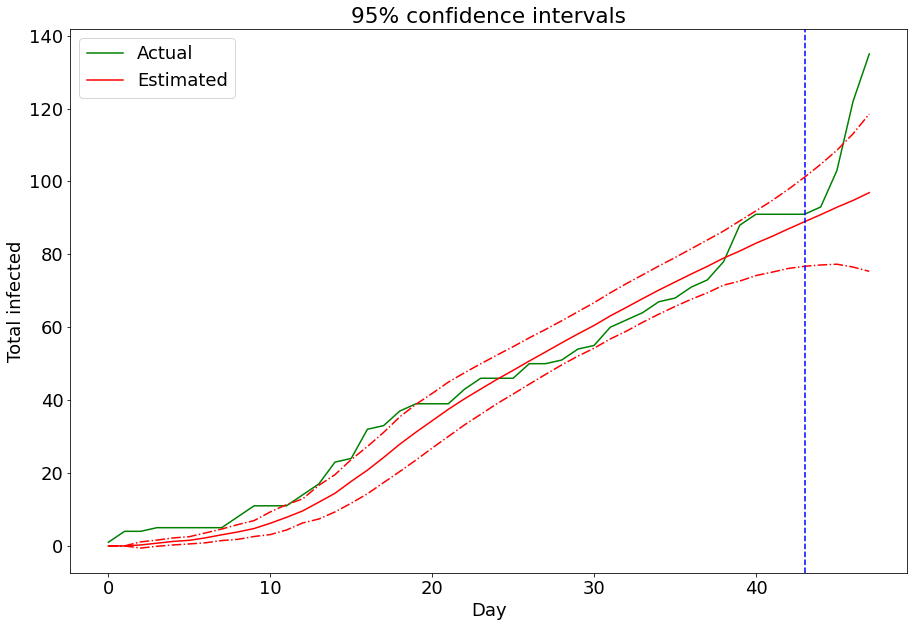

In [25]:
visualize()

## Visualize all runs separately

100%|██████████| 48/48 [00:06<00:00,  6.97it/s]


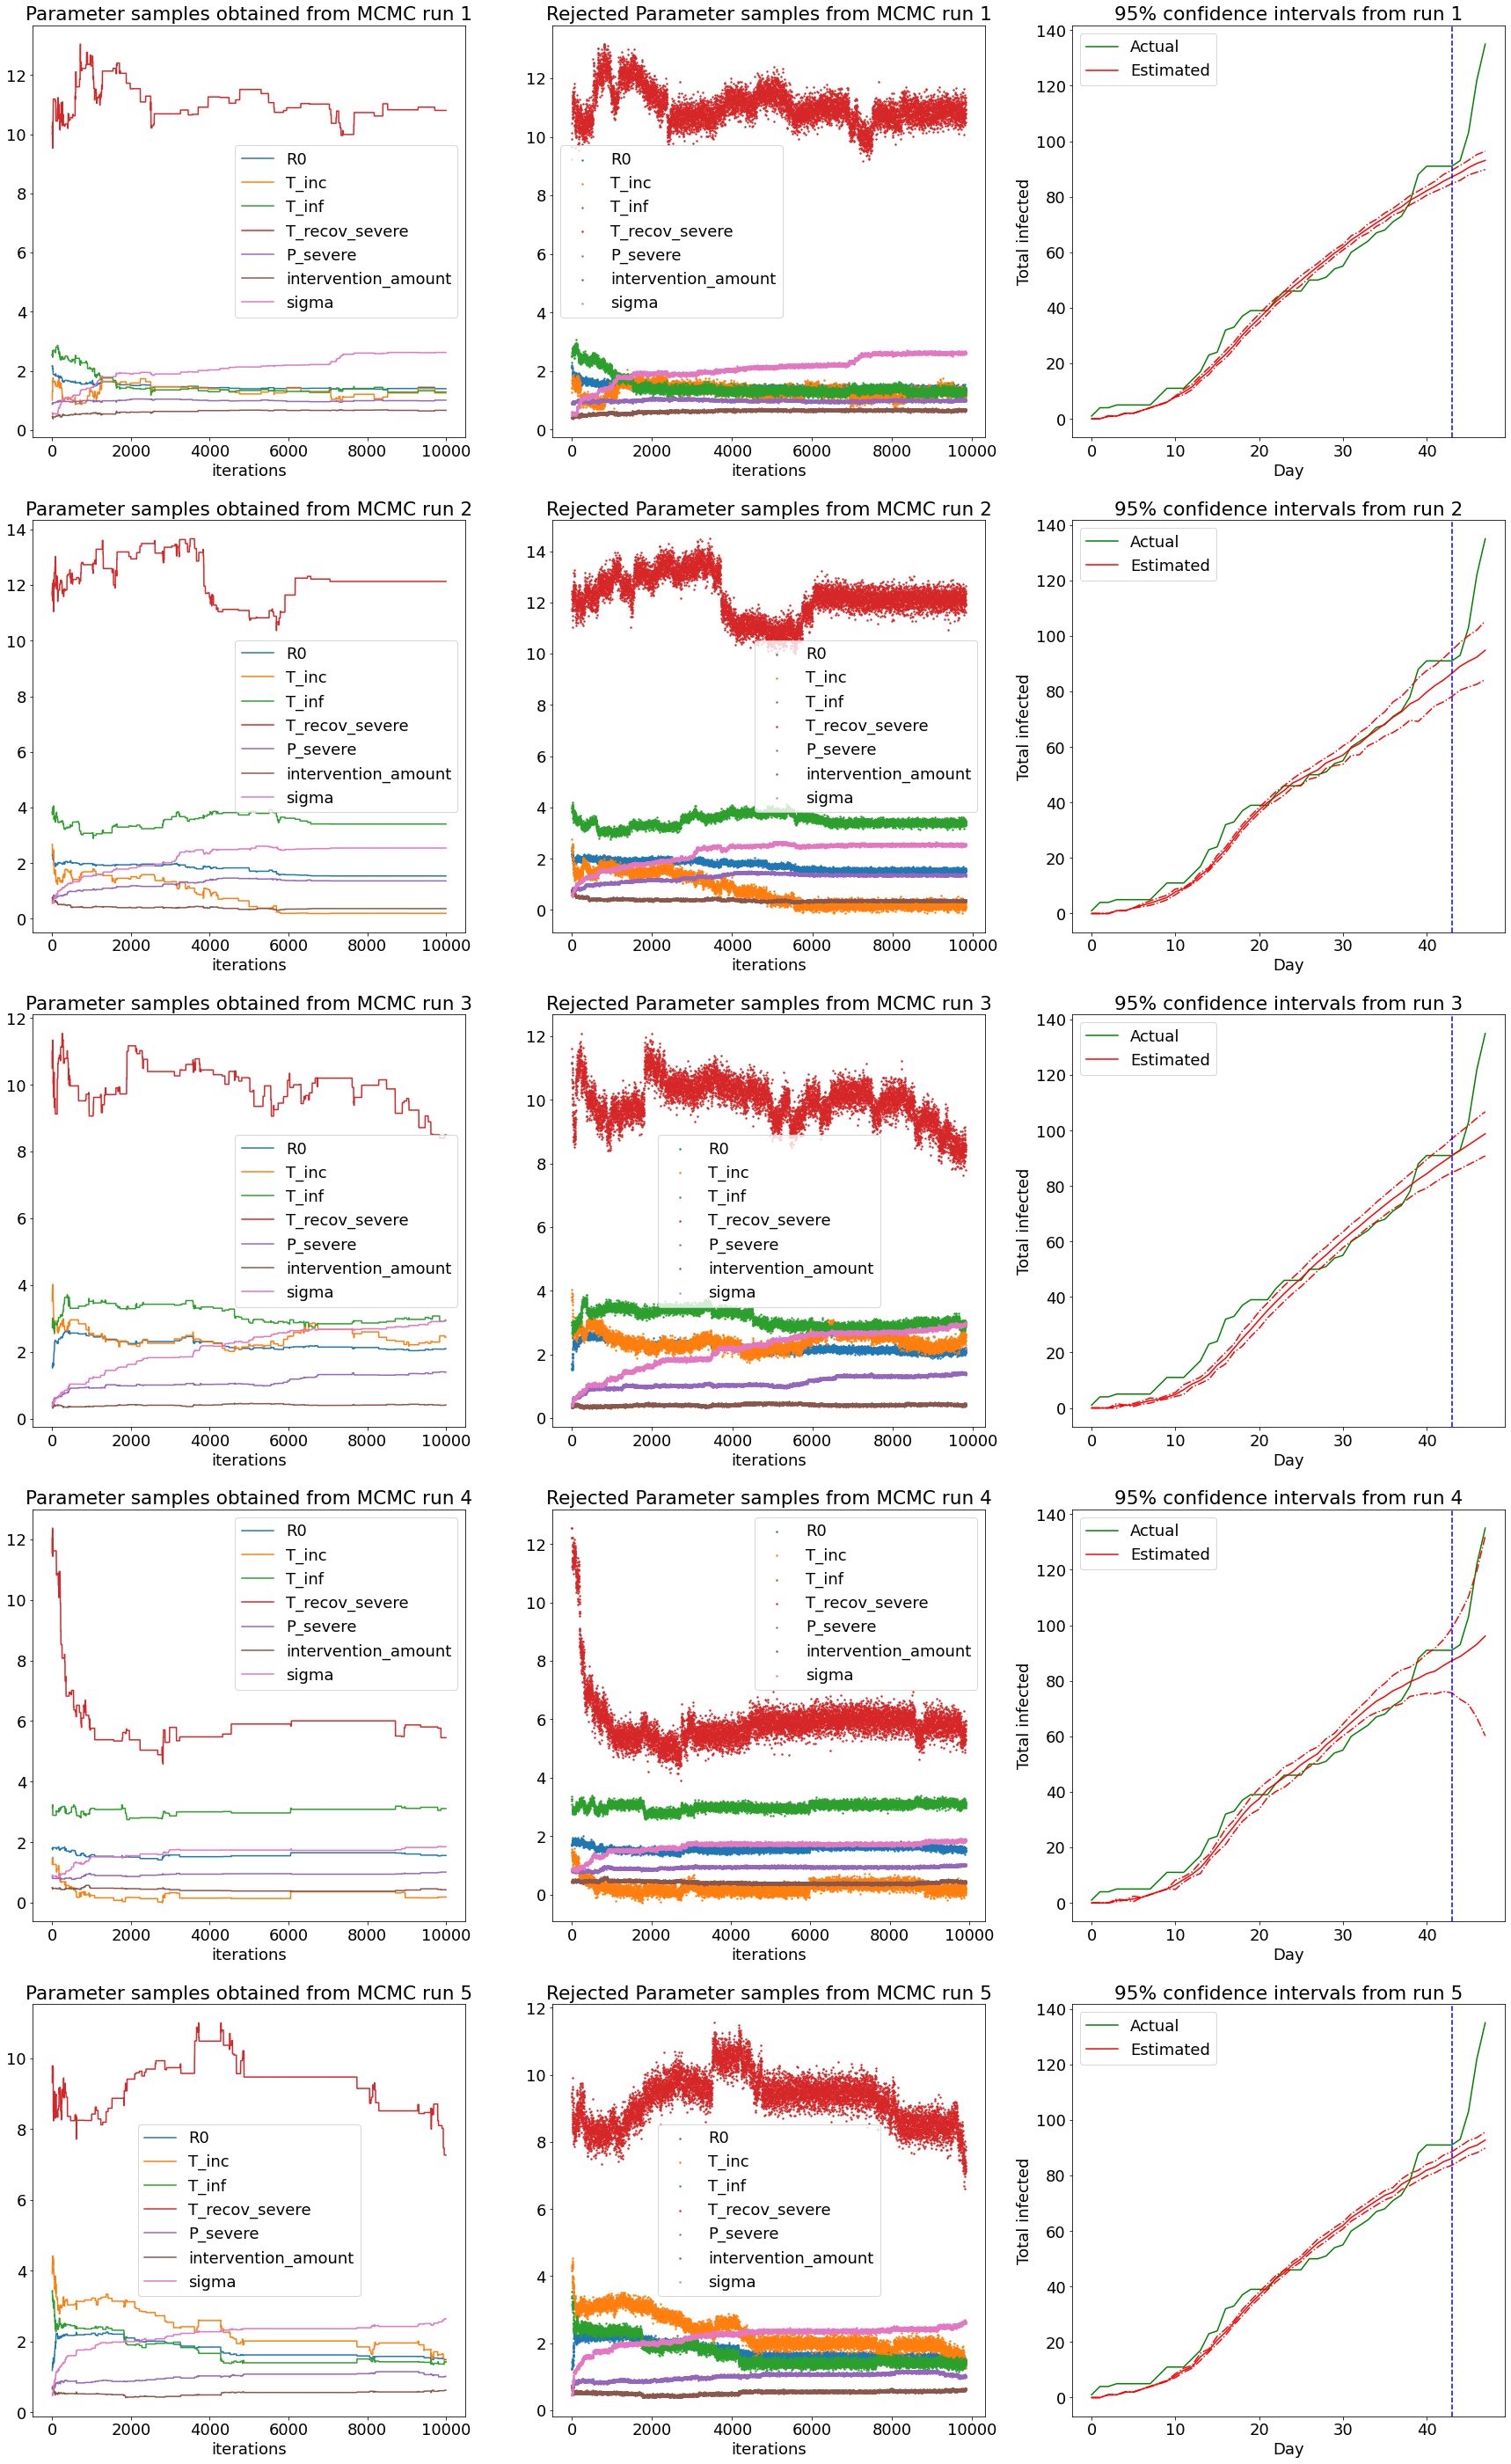

In [27]:
plt.figure(figsize=(30, 50))
    
for k, run in enumerate(mcmc):
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    acc, rej = run[0], run[1]
    df_samples = pd.DataFrame(acc)
    
    plt.subplot(len(mcmc), 3, 3*k + 1)
    for param in df_samples.columns:
        plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Parameter samples obtained from MCMC run {}".format(k+1))
    
    rej_samples = pd.DataFrame(rej)
    
    plt.subplot(len(mcmc), 3, 3*k + 2)
    for param in rej_samples.columns:
        plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Rejected Parameter samples from MCMC run {}".format(k+1))
    
    burn_in = int(len(acc) / 2)
    n_samples = 1000
    posterior_samples = acc[burn_in:]
    sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))
        
    for df in pred_dfs:
        df.set_index('date', inplace=True)
        
    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''
        
    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)
            
    data_split.set_index("date", inplace=True)

    plt.subplot(len(mcmc), 3, 3*k + 3)
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% confidence intervals from run {}".format(k+1))
    
plt.savefig("./mcmc_runs.png")
plt.show()